# 线性回归基础实现
```
最简训练步骤：
1、初始化模型参数: w,b
2、设置超参数: lr,num_epochs
3、前向传播: 计算出y_hat
4、计算出loss: （关于y_hat 与 y 的）squared_loss
5、反向传播，计算梯度: （参数w、b关于loss函数的梯度）【注意：反向传播之前必须清除上一个 epoch 保存的梯度】
6、使用梯度，更新参数: Optimization Algorithm （sgd、Adagrad、Adam等） 【注意：with torch.no_grad():】
7、重复步骤3-6，num_epochs次。
```

In [25]:
import random
import torch
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

In [26]:
# 设置plt可以显示中文字体，否则会显示乱码
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)

In [27]:
"""
生成加入噪声的测试数据
生成y=Xw+b+噪声
"""
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w))) # 高斯分布(正态分布)
    # X = torch.rand((num_examples,len(w))) # 均匀分布
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

# 生成测试数据
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
features.shape,labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

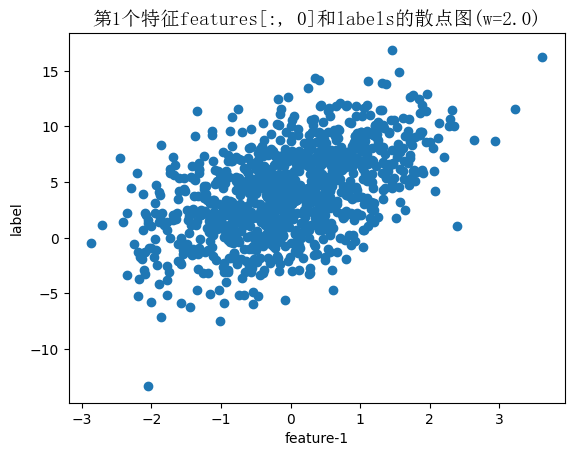

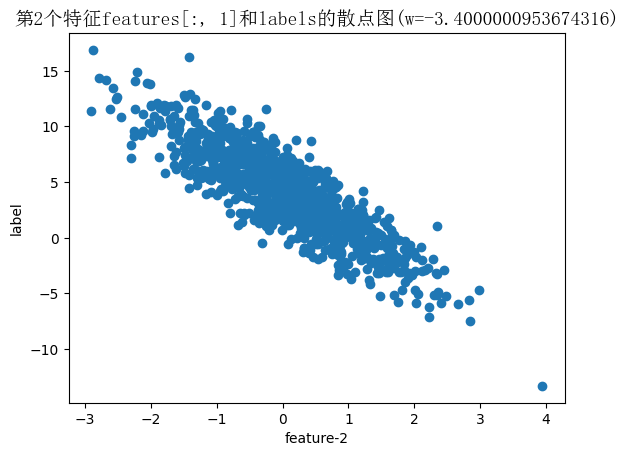

In [28]:
%matplotlib inline

"""
查看测试数据散点图
"""
for i in range(len(true_w)):
    plt.scatter(features[:, i], labels)
    plt.xlabel(f"feature-{i+1}")
    plt.ylabel(f"label")
    plt.title(f"第{i + 1}个特征features[:, {i}]和labels的散点图(w={true_w[i]})", fontproperties=font)
    plt.show()


In [29]:
"""
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为 batch_size 的小批量.
每个小批量包含一组特征和标签。
"""
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        # 最后一个批次数据，应该特殊处理，防止最后一个batch 数据量过小。或者设置恰好被 数据总量 整除的 batch_size
        yield features[batch_indices], labels[batch_indices]


In [30]:
"""
初始化模型参数
# 从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0
"""
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)


In [31]:
"""线性回归模型"""
def linreg(X, w, b):
    return torch.matmul(X, w) + b


In [32]:
"""均方损失函数"""
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2


In [33]:
"""小批量随机梯度下降 sgd算法"""
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


In [34]:
"""设置超参数"""
lr = 0.03 # 学习率
batch_size = 32 # 数据批量大小
num_epochs = 10 # 训练轮数
net = linreg # 线性回归 神经网络单元
loss = squared_loss # 损失函数
train_all_dataset_loss_list = [] # 用于保存历史loss均值

In [35]:
# 训练
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        # print(y.shape)
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_all_dataset_loss = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, 平均mean loss {float(train_all_dataset_loss.mean()):f}')
        train_all_dataset_loss_list.append(train_all_dataset_loss.mean())

print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

epoch 1, 平均mean loss 2.462891
epoch 2, 平均mean loss 0.370122
epoch 3, 平均mean loss 0.055859
epoch 4, 平均mean loss 0.008485
epoch 5, 平均mean loss 0.001336
epoch 6, 平均mean loss 0.000251
epoch 7, 平均mean loss 0.000086
epoch 8, 平均mean loss 0.000061
epoch 9, 平均mean loss 0.000057
epoch 10, 平均mean loss 0.000057
w的估计误差: tensor([0.0004, 0.0001], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0003], grad_fn=<RsubBackward1>)


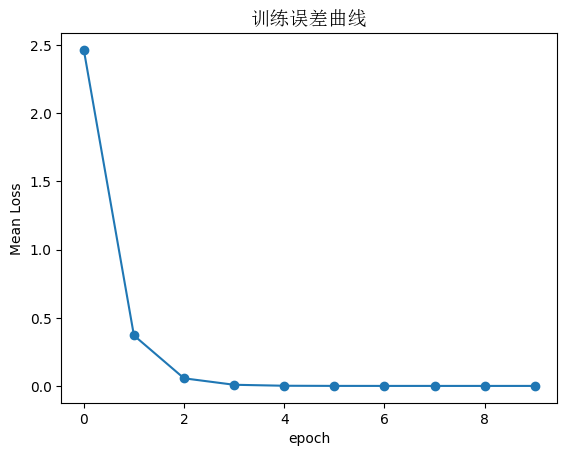

In [36]:
# 画图-训练误差曲线
train_all_dataset_loss_list_Y = train_all_dataset_loss_list
train_all_dataset_loss_list_X = [i for i in range(len(train_all_dataset_loss_list_Y))]
plt.plot(train_all_dataset_loss_list_X, train_all_dataset_loss_list_Y,marker='o')
plt.title("训练误差曲线", fontproperties=font)
plt.xlabel("epoch")
plt.ylabel("Mean Loss")
plt.show()
